# Data & Apprentissage, M2CHPS

## Assignments - Part 1

**Lecturer:** [Argyris Kalogeratos](http://kalogeratos.com) (contact: argyris.kalogeratos@ens-paris-saclay.fr).   
**Sylabus:** [http://nvayatis.perso.math.cnrs.fr/CHPScourse-2024.html](http://nvayatis.perso.math.cnrs.fr/CHPScourse-2023.html)

The most updated version of this file can be found at the webpage:  
[http://kalogeratos.com/MyCourses/DML-M2HPC/Assignments1.ipynb](http://kalogeratos.com/psite/files/MyCourses/DML-M2HPC/Assignments1.ipynb).

## 0. Before you start

* Work on the assignment either alone or in a team of two (pair). Students that will work alone will benefit from a 15% bonus. Important: The point in working in a pair is not to split the work, but to collaborate! 
* Prepare **a single jupiter notebook** in a report-like format for all the exercises. Use this notebook as a starting point and place your answers just below each exercise. Describe properly what you do in each step of your solution, followed by your well-commented code implementation that can automatically produce figures and numerical results. Results should also be well-commented and discussed. Your comments can be either in English or in French.
* If you need to provide mathematical expressions, incorporate all that in your notebook in a latex form (not handwritten!). 
* Important: send your notebook that includes all your work and any additional files you used (e.g. datasets) at by email, with a title ``M2CHPS <year> - <Surname1> & <Surname2>``. The title of the notebook should have the surnames of the students. The body of the email should also mention the students' names and how the work was split among them; if you face difficulties in precising this with your classmate, please write individual emails. 
* Always use references for things you reuse (e.g. internet, forums, books, published papers, etc.)
* Do not copy-paste from the internet recipies that do the asked thing (or what is most usually observed: to use something relevant but not exactly what is asked). You need to understand what you use (sources should be properly referenced), adapt it to what each exercise asks for, and comment clearly the results. Poorly commented and explained pieces of work/code will not be taken seriously into account. 
* Copying from one another is not acceptable. We are strict with that: cheating in even one exercise will incur **a zero to all projects** (not just one assignement) and possible disqualification from the exams. Your work will be cross-checked against anything similar submitted from past students of the course.
* The assignments will be examined orally at the end of the semester. Each group of students should be able to explain in about 10 mins all what they did, and answer short questions.
* **Deadline: midnight of Monday 20/10**. 

## Exercise 1 - [30%]
Read about the iterative [RANdom SAmple Consensus (RANSAC)](https://en.wikipedia.org/wiki/Random_sample_consensus) method for robust linear regression. Consult also the material of the Lab and the documentation of scikit learn.

**a)** Implement from scratch your own code for the RANSAC algorithm. You can still use as a building block the native linear regression of scikit learn in your implementation. Then, compare it with the simple linear regression and the build-in RANSAC implementation of scikit learn.

a1) Apply your solution to the dataset of the example given in [Lab 2](http://kalogeratos.com/MyCourses/DML-M2HPC/Lab2.ipynb) to see that it  matches the behavior of the already coded method of scikit learn. Create plots including the linear models found by the typical linear regressor, the scikit RANSAC, and you version(s).

a2) Apply your method to the following cases:
* Use only the part of the inliners that comes from the inclined linear model (about 1000 points). Add extra $p$% of noisy points (where $p$ can be 5%, 10%, 20%, 30%) by picking random elements of the data and perturbing them "sufficiently" with a Gaussian noise so that they get dislocated far from the rest of the data on both sides.
* Do as before, but constrain the perturbation to be only positive (all noisy points will be above the inline data).
* Do as before, but the perturbed data will not be randomly selected, but rather correspond to the $p$% of the points with lower $y$ coordinate (the points at the lower left part of the plot).

What differences do you observe among these cases. Report with illustrative results and comments. You can test additional cases using the same data generation code, after changing some of the parameters (e.g. the number of outliers and their distance to the inliers). 

Simple Linear Regression MSE: 0.7430610341321241
Sklearn RANSAC MSE: 1.599460963520926
Custom RANSAC MSE: 1.1726023896577755


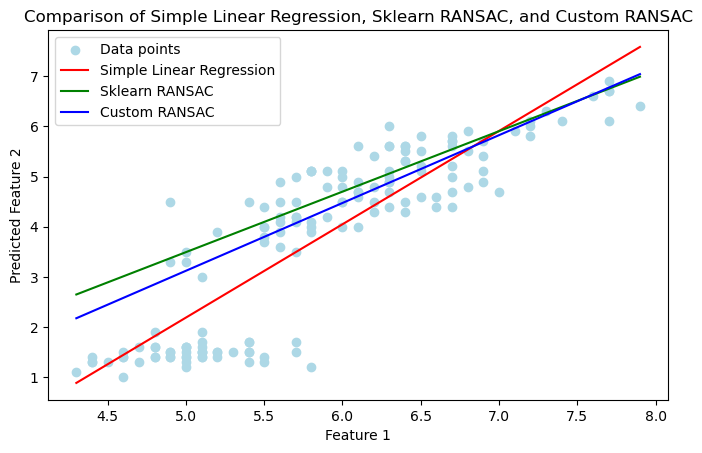

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error
from sklearn import datasets

# Load the iris dataset
iris = datasets.load_iris()
X = iris.data[:, :1]  # Only use the first feature for simplicity (to make sure it's linear)
y = iris.data[:, 2]  # Predict one of the other features

# Custom RANSAC Algorithm implementation
def ransac(data, model, n, k, t, d):
    iterations = 0
    bestFit = None
    bestErr = float('inf')  # Initialize bestErr to a very large number
    
    X, y = data
    n_points = len(X)

    while iterations < k:
        # Randomly sample n points from the data to estimate model parameters
        maybe_inliers_idx = np.random.choice(n_points, n, replace=False)
        X_maybe_inliers = X[maybe_inliers_idx]
        y_maybe_inliers = y[maybe_inliers_idx]

        # Fit the model to the maybe inliers
        maybe_model = model()
        maybe_model.fit(X_maybe_inliers, y_maybe_inliers)

        # Identify confirmed inliers
        confirmed_inliers = []
        for i in range(n_points):
            y_pred = maybe_model.predict(X[i].reshape(1, -1))
            error = np.abs(y[i] - y_pred)
            if error < t:
                confirmed_inliers.append(i)

        # Check if we have a valid model (sufficient number of inliers)
        if len(confirmed_inliers) > d:
            X_confirmed_inliers = X[confirmed_inliers]
            y_confirmed_inliers = y[confirmed_inliers]

            # Refit the model with all inliers
            better_model = model()
            better_model.fit(X_confirmed_inliers, y_confirmed_inliers)

            # Calculate error (e.g., mean squared error)
            y_pred = better_model.predict(X_confirmed_inliers)
            thisErr = mean_squared_error(y_confirmed_inliers, y_pred)

            # If error is better than current best, update the best model
            if thisErr < bestErr:
                bestFit = better_model
                bestErr = thisErr

        iterations += 1

    return bestFit


# Set parameters for custom RANSAC
n = 10  # Minimum number of data points required to estimate the model
k = 100  # Maximum number of iterations
t = 0.5  # Threshold to determine inliers
d = 30  # Minimum number of inliers

# Custom RANSAC model
custom_ransac_model = ransac((X, y), LinearRegression, n, k, t, d)


# Simple Linear Regression
simple_lr = LinearRegression()
simple_lr.fit(X, y)
y_pred_simple = simple_lr.predict(X)
mse_simple = mean_squared_error(y, y_pred_simple)


# Sklearn Built-in RANSAC
sklearn_ransac = RANSACRegressor(estimator=LinearRegression(), min_samples=n, residual_threshold=t)  # Fixed 'estimator' argument
sklearn_ransac.fit(X, y)
y_pred_sklearn_ransac = sklearn_ransac.predict(X)
mse_sklearn_ransac = mean_squared_error(y, y_pred_sklearn_ransac)


# Custom RANSAC Predictions
if custom_ransac_model:
    y_pred_custom_ransac = custom_ransac_model.predict(X)
    mse_custom_ransac = mean_squared_error(y, y_pred_custom_ransac)
else:
    print("No valid model found for Custom RANSAC")
    mse_custom_ransac = None


# Compare results
print(f"Simple Linear Regression MSE: {mse_simple}")
print(f"Sklearn RANSAC MSE: {mse_sklearn_ransac}")
if mse_custom_ransac is not None:
    print(f"Custom RANSAC MSE: {mse_custom_ransac}")
else:
    print("Custom RANSAC did not find a good model.")


# Sort data for plotting
sorted_idx = np.argsort(X[:, 0])  # Sort by the first feature
X_sorted = X[sorted_idx]
y_sorted = y[sorted_idx]

# Sort predictions according to the sorted indices
y_pred_simple_sorted = y_pred_simple[sorted_idx]
y_pred_sklearn_ransac_sorted = y_pred_sklearn_ransac[sorted_idx]
if custom_ransac_model:
    y_pred_custom_ransac_sorted = y_pred_custom_ransac[sorted_idx]

# Plot the results for comparison
plt.figure(figsize=(8, 4.8))

# Original data points
plt.scatter(X[:, 0], y, color="lightblue", label="Data points")

# Simple Linear Regression
plt.plot(X_sorted[:, 0], y_pred_simple_sorted, color="red", label="Simple Linear Regression")

# Sklearn RANSAC
plt.plot(X_sorted[:, 0], y_pred_sklearn_ransac_sorted, color="green", label="Sklearn RANSAC")

# Custom RANSAC
if custom_ransac_model:
    plt.plot(X_sorted[:, 0], y_pred_custom_ransac_sorted, color="blue", label="Custom RANSAC")

plt.legend()
plt.title("Comparison of Simple Linear Regression, Sklearn RANSAC, and Custom RANSAC")
plt.xlabel("Feature 1")
plt.ylabel("Predicted Feature 2")
plt.show()


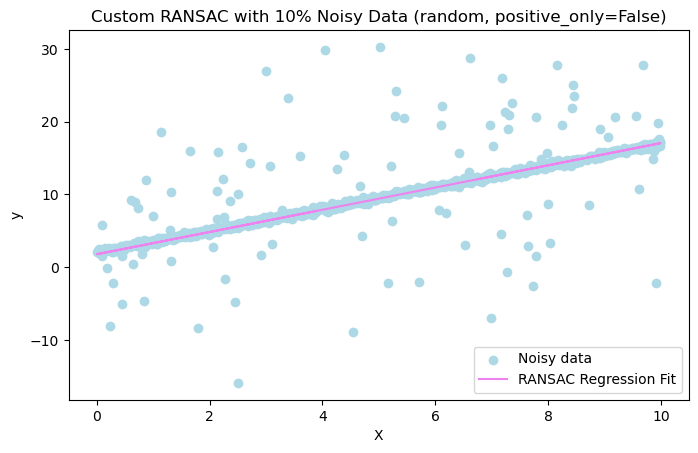

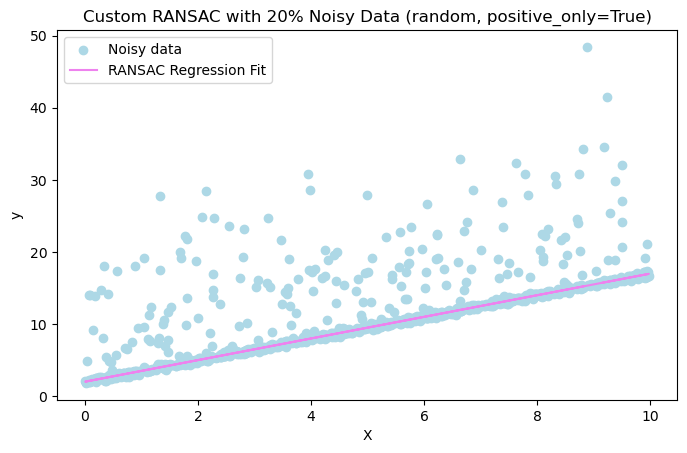

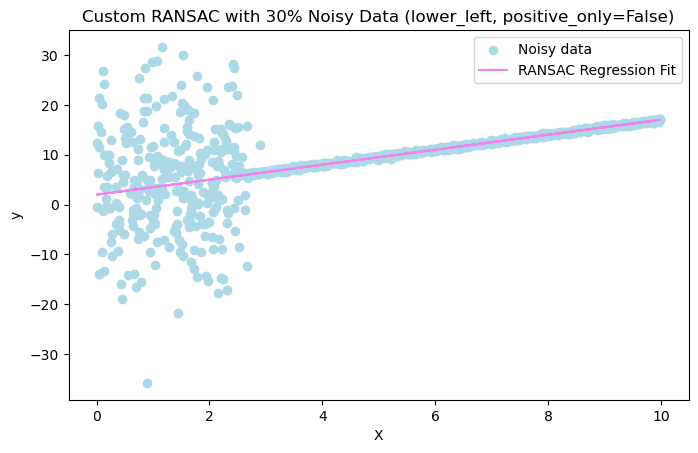

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Custom RANSAC Algorithm implementation (same as before)
def ransac(data, model, n, k, t, d):
    iterations = 0
    bestFit = None
    bestErr = float('inf')  # Initialize bestErr to a very large number
    
    X, y = data
    n_points = len(X)

    while iterations < k:
        # Randomly sample n points from the data to estimate model parameters
        maybe_inliers_idx = np.random.choice(n_points, n, replace=False)
        X_maybe_inliers = X[maybe_inliers_idx]
        y_maybe_inliers = y[maybe_inliers_idx]

        # Fit the model to the maybe inliers
        maybe_model = model()
        maybe_model.fit(X_maybe_inliers, y_maybe_inliers)

        # Identify confirmed inliers
        confirmed_inliers = []
        for i in range(n_points):
            y_pred = maybe_model.predict(X[i].reshape(1, -1))
            error = np.abs(y[i] - y_pred)
            if error < t:
                confirmed_inliers.append(i)

        # Check if we have a valid model (sufficient number of inliers)
        if len(confirmed_inliers) > d:
            X_confirmed_inliers = X[confirmed_inliers]
            y_confirmed_inliers = y[confirmed_inliers]

            # Refit the model with all inliers
            better_model = model()
            better_model.fit(X_confirmed_inliers, y_confirmed_inliers)

            # Calculate error (e.g., mean squared error)
            y_pred = better_model.predict(X_confirmed_inliers)
            thisErr = mean_squared_error(y_confirmed_inliers, y_pred)

            # If error is better than current best, update the best model
            if thisErr < bestErr:
                bestFit = better_model
                bestErr = thisErr

        iterations += 1

    return bestFit


# Generate inline data for the inclined linear model
def generate_inliner_data(n_points=1000, slope=1.5, intercept=2.0, noise_std=0.2):
    X = np.random.rand(n_points, 1) * 10  # Random X values in [0, 10]
    y = slope * X + intercept + np.random.randn(n_points, 1) * noise_std  # Linear model with Gaussian noise
    return X, y

# Add noisy points by perturbing randomly selected points from the inliner data
def add_noisy_points(X, y, p, mode='random', positive_only=False):
    n_noisy = int(p * X.shape[0] / 100)  # Number of noisy points
    X_noisy, y_noisy = np.copy(X), np.copy(y)
    
    if mode == 'random':
        # Randomly select p% of points to add noise
        noisy_idx = np.random.choice(X.shape[0], n_noisy, replace=False)
    elif mode == 'lower_left':
        # Select the points with the lowest y-values (bottom left)
        noisy_idx = np.argsort(y[:, 0])[:n_noisy]
    
    for idx in noisy_idx:
        noise = np.random.randn() * 10  # Large Gaussian noise
        if positive_only:
            y_noisy[idx] += np.abs(noise)  # Ensure noise is positive
        else:
            y_noisy[idx] += noise  # Random positive or negative noise
    
    return X_noisy, y_noisy

# Plotting the results
def plot_ransac_results(X, y, y_pred, title):
    plt.figure(figsize=(8, 4.8))
    plt.scatter(X, y, color="lightblue", label="Noisy data")
    plt.plot(X, y_pred, color="violet", label="RANSAC Regression Fit")
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.show()


# Apply the method for the three cases
def run_ransac_with_noisy_data(p, mode='random', positive_only=False):
    # Generate inliner data
    X_inliners, y_inliners = generate_inliner_data()

    # Add noisy points
    X_noisy, y_noisy = add_noisy_points(X_inliners, y_inliners, p, mode, positive_only)

    # Apply custom RANSAC
    custom_ransac_model = ransac((X_noisy, y_noisy), LinearRegression, n=50, k=100, t=1.0, d=500)
    
    # Generate predictions for the full dataset
    y_pred_custom_ransac = custom_ransac_model.predict(X_noisy)

    # Plot the results
    plot_ransac_results(X_noisy, y_noisy, y_pred_custom_ransac, f"Custom RANSAC with {p}% Noisy Data ({mode}, positive_only={positive_only})")


# Running for different cases
run_ransac_with_noisy_data(10, mode='random', positive_only=False)  # 10% random noisy points, both positive and negative noise
run_ransac_with_noisy_data(20, mode='random', positive_only=True)   # 20% random noisy points, only positive noise
run_ransac_with_noisy_data(30, mode='lower_left', positive_only=False)  # 30% noise at lower left part of the data


## Exercise 1 - [30%]

**b)** The original RANSAC uses inlying data points as votes for candidate models. An alternative is to use the opposite approach: i.e. to use the models to vote for the most inlying points. Implement this variation that operates as follows:
- Each time you subsample from the data, build a linear model, all inliers get a vote +1.
- After having built the predefined number of models, use the top q% (e.g. 75%) voted points and build the final linear model using only those points.

Use the previous dataset or/and other variations you may generate to demonstrate differences in performance, and discuss the results.

## Exercise 1 - [30%]

**c)** As discussed in the class, the logic behind the RANSAC could actually be seen as a more general tool than just performing regression. More specifically, it can be seen as a way to perfom various kinds of *robust estimation*. 

<img src="./cloud-of-points-outliers.png" alt="Drawing" style="width: 500px;"/>

c1) Assume for example the problem where we have a point-cloud of data and we want to estimate their "center", as a group representative, but in a robust way. The figure above illustrates an example where the input data contains $100$ inliers and $10$ outliers, which however you don't know a priori. Here, the inliers come from a Gaussian distribution with $\mu = (0,0)$ and $\sigma = 0.83$, while the ouliers come from a Gaussian dislocated at $\mu = (0,0)$ and $\sigma = 1.5$. You can get the [.mat data file](http://kalogeratos.com/psite/files/MyCourses/DML-M2HPC/cloud-of-points-data.mat) with this example and/or write your own code to generate it. 

How would you design a solution to this problem that adopts the RANSAC principle so that for this kind of data input we can compute a representative as close as possible to the mean of the inliers?

c2) Extend this approach to the clustering of the data in a given number of $k$ clusters by considering a centroid-based clustering method (e.g. $k$-means) as the  internal model learner. Provide an implementation and demonstrate some example(s).

c3) Write an abstract pseudocode that expresses the generalization of RANSAC in arbitrary statistical estimation or learning problems? 

## Exercise 2 - [15%]

In Section 2.5 of the book "[The Elements of Statistical Learning: Data Mining, Inference, and Prediction](https://web.stanford.edu/~hastie/ElemStatLearn//printings/ESLII_print12_toc.pdf)", by T. Hastie, R. Tibshirani, and J. Friedman, there is a mention about the effects of the *curse of dimensionality*. Read the section and implement the code to reproduce and verify all the experiments shown in the Figures 2.6, 2.7, 2.8, and 2.9.
	

## Exercise 3 - [15%]

**a)** The rule of thumb for **train/test split** ratio is to choose it to be quite larger than 1 (e.g a 75%-25% train/test split). Validate empirically this choice:

* Choose a dataset for a classification task.
* Use a classification method that is suitable for the problem (i.e. performs reasonably well on the dataset).
* Try several train/test split ratio values (e.g. 0% to 100% with step 5%).
* Use plot(s) to display the performance of the method on the test set in each case.
* Justify in detail the observed behavior using arguments founded in the theory (see bias-variance trade off).
* What is (approx.) the best choice of ratio in your case?
* Now, using a train/validation/test split, optimize the hyperparameters of your model, and give the final trained model that you would deliver for practical use. 

**b)** *Cross-validation* splits the set of data in non-overlapping parts, then learns and tests the performance of a method independently in the different parts of the data, e.g. i) train-test set split, or ii) k-folded approach. 

Imagine that you have to apply (i) and (ii) for validating a regression method for time-series, a task which is also referred as *time-series forecasting*. Note that in this case the element of time should be respected.

Describe a procedure, by giving a pseudocode, that would apply (i) and (ii).



## Exercise 4 - [20%]

The purpose of this exercise is to apply classification for two data classes using a **simple linear model**. However, the particularity is that we are in the context of *stream processing* where data arrive sequentially in pairs of observations, containing one observation from each class, i.e. each time $t$ we observe $(x_t \in \text{class A}, x'_t \in \text{class B})$. As *we cannot store all the data* to apply batch processing, we need to develop a frugal online learning approach that would require as little as possible stored information at each time $t$ for a simple linear model $model_t$, which then would be updated based on the incoming $(x_t, x'_t)$'s. At any time $t$ the model $model_t$ should be able to classify uknown data.

**a)** Analyze in detail the requirements of this problem setting, and implement an approach to produce a linear model for all the data of the stream. Explain why it is correct and how much memory resources it would need to run.

**b)** To train your model consider $N = n+n$ data produced two 2D Gaussian distributions ($n$ instances from each of them) that have (e.g.) same standard deviation and different mean values $\mu_1$ and $\mu_2$. Use a large $N$ (e.g. $500$) and show the performance of $model_t$ at the course of time (i.e. for $t=1,...,N$) using a test-set of $500 + 500$ datapoints generated from the same distributions. Compare in the same plot (e.g. it would appear as fixed horizontal line) against a linear classifier that is trained directly on the $N$ datapoints. Use a couple of $\mu_1$ and $\mu_2$ pairs to show an easy case and a more difficult one.



## Exercise 5 - [10%]

Relying on the central hypothesis that a learning problem should enjoy regularity along the domain of the data (see [Lab 1](http://kalogeratos.com/MyCourses/DML-M2HPC/Lab1.ipynb)), we would like to define a heuristic data-driven measure to evaluate a given model.

More specifically, consider a classification problem and define a regularity measure based on the nearest neighbors principle that can assess how regular the decisions of a given classifier is. Explain the logic of your proposition. Let's call this function **Regularity(X, Y, +any needed parameters)**.

**Recipe for testing**

In this exercise you have to generated data from a mixture of 2 Gaussian distributions, and then measure the effect of your Regularity measure and the standard Accuracy with regards to the following factors:

* the size of the dataset; try generating classes of same standard deviation $\sigma = 2$ and equal size, where each of them will have $n_i\in\{50, 100, 200, 500\}$ objects;
* the dimensionality $d$ of the data; try $d\in\{1,2,3,...\,,10, 20, 30,...\,100\}$;
* the overlap of the classes $\delta$ in the feature space, i.e. the distance between the classes; try $\delta\in\{\sigma, 2\sigma, 3\sigma, 4\sigma\}$;
* the input parameter $k$ which indirectly adjusts how far from an object the classifier will seek for `advices' from other objects in order to classify it; try $k\in\{1,...\,,10\}$.

**Sample pseudocode:**  

for each tuple <$n$, $d$, $\delta$, $k$>
   * generate data  
   * compute average quality over $10$ runs of the following  
       * train a $k$NN classifier and a decision tree (choose nicely the depth)   
       * test the classifiers using Accuracy and Regularity  

end for

The evaluation should be performed with and without 10-fold CV (inside the train/test nested part). Use at least the suggested value range for each parameter, but you can extend it if this way you capture some interesting behavior. 

**Questions:** 
- What is the main difference between a $k$NN and a radius-NN classifier? In which case(s) one is better to the other? How would we have to adapt the above discussion if radius-NN classifier is used instead of the standard $k$NN?
- What would change if we were interested in measuring the Regularity in the context of a regression problem?

## Exercise 6 - [10%]

Apply ridge regression and lasso regression on the diabetes dataset. Use all the features but the 11th as input parameters, and the 11th as target (it's an index showing the progression of the disease). 
* Search for a good $a$ regularization penalty using Cross Validation (use built-in functions of scikit-learn) for each method, as in the examples 4 and 5 of Lab 2. 
* Generate plots that show the evolution of all the coefficients (the elements of the $w$ vector) and -in a second plot- regression scores such as the resiguals and the [$R^2$ measure](https://en.wikipedia.org/wiki/Coefficient_of_determination) showing how well the model fits to the data.
* Discuss your comparative findings.

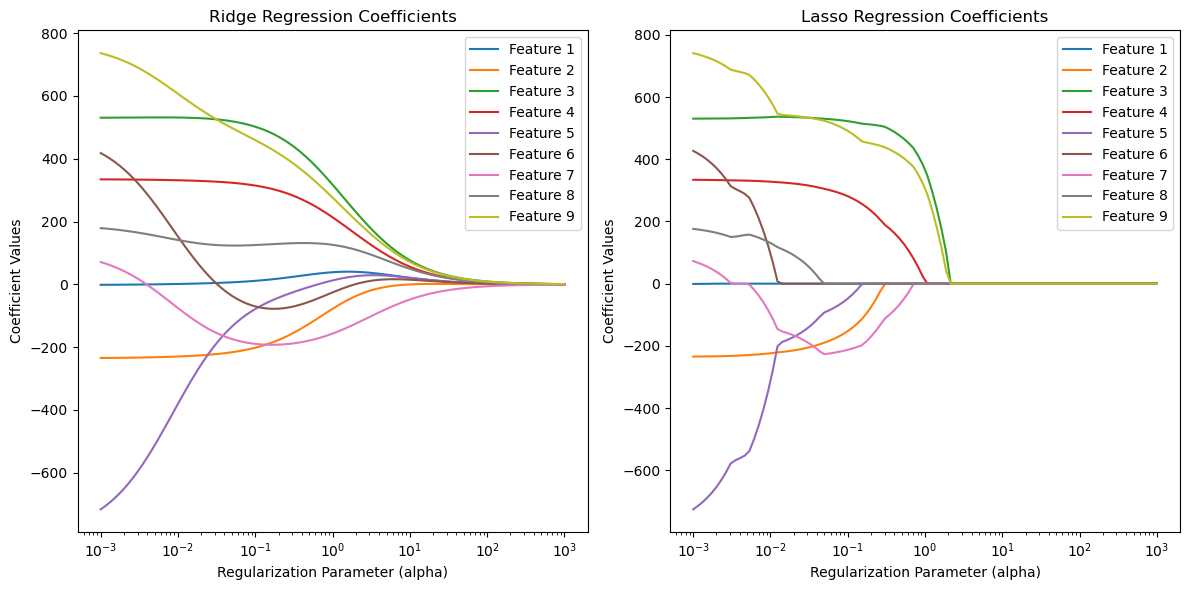

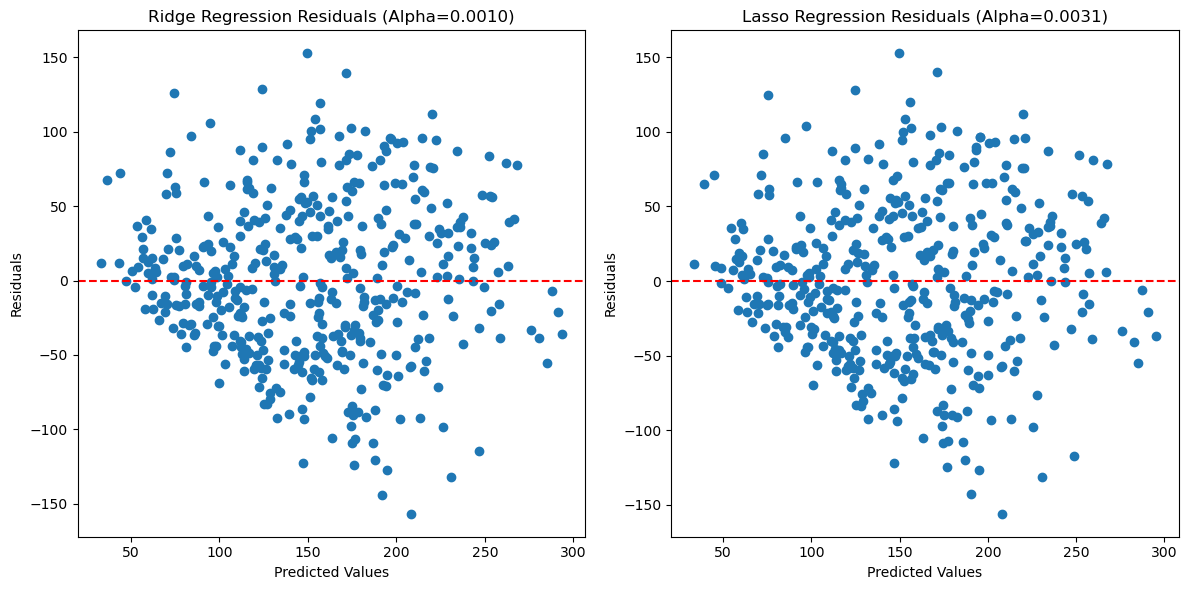

Best Ridge Alpha: 0.001
Best Lasso Alpha: 0.0030538555088334154
Ridge MSE: 2866.9181561324604
Lasso MSE: 2868.55700497121


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

diabetes = datasets.load_diabetes()
X = diabetes.data[:, :-1]  
y = diabetes.target  

alphas = np.logspace(-3, 3, 100) 

ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X, y)
best_ridge_alpha = ridge_cv.best_params_['alpha']
ridge_best = Ridge(alpha=best_ridge_alpha)
ridge_best.fit(X, y)

lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X, y)
best_lasso_alpha = lasso_cv.best_params_['alpha']
lasso_best = Lasso(alpha=best_lasso_alpha, max_iter=10000)
lasso_best.fit(X, y)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(X.shape[1]):
    plt.plot(alphas, [Ridge(alpha=a).fit(X, y).coef_[i] for a in alphas], label=f'Feature {i+1}')
plt.xscale('log')
plt.xlabel('Regularization Parameter (alpha)')
plt.ylabel('Coefficient Values')
plt.title('Ridge Regression Coefficients')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(X.shape[1]):
    plt.plot(alphas, [Lasso(alpha=a, max_iter=10000).fit(X, y).coef_[i] for a in alphas], label=f'Feature {i+1}')
plt.xscale('log')
plt.xlabel('Regularization Parameter (alpha)')
plt.ylabel('Coefficient Values')
plt.title('Lasso Regression Coefficients')
plt.legend()

plt.tight_layout()
plt.show()

ridge_pred = ridge_best.predict(X)
lasso_pred = lasso_best.predict(X)

ridge_residuals = y - ridge_pred
lasso_residuals = y - lasso_pred

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(ridge_pred, ridge_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Ridge Regression Residuals (Alpha={best_ridge_alpha:.4f})')

plt.subplot(1, 2, 2)
plt.scatter(lasso_pred, lasso_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Lasso Regression Residuals (Alpha={best_lasso_alpha:.4f})')

plt.tight_layout()
plt.show()

print(f"Best Ridge Alpha: {best_ridge_alpha}")
print(f"Best Lasso Alpha: {best_lasso_alpha}")
print(f"Ridge MSE: {mean_squared_error(y, ridge_pred)}")
print(f"Lasso MSE: {mean_squared_error(y, lasso_pred)}")
